In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

import torch
from torch.utils.data import DataLoader


In [2]:
import contrail

model = contrail.ContrailModel("UNet", in_channels=3, out_classes=1)
model.load_state_dict(torch.load("data/model/contrail.torch.states.v4.dice.8000.bin"))

model2 = contrail.ContrailModel("UNet", in_channels=3, out_classes=1)
model2.load_state_dict(torch.load("data/model/contrail.torch.states.v7.focal.8000.bin"))

model3 = contrail.ContrailModel("UNet", in_channels=3, out_classes=1)
model3.load_state_dict(torch.load("data/model/contrail.torch.states.v12.sr.4000.bin"))


/home/junzi/mambaforge/envs/contrail/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [3]:
outpath = "/home/junzi/ace/workspace/paper/j12_contrail/code/data/"


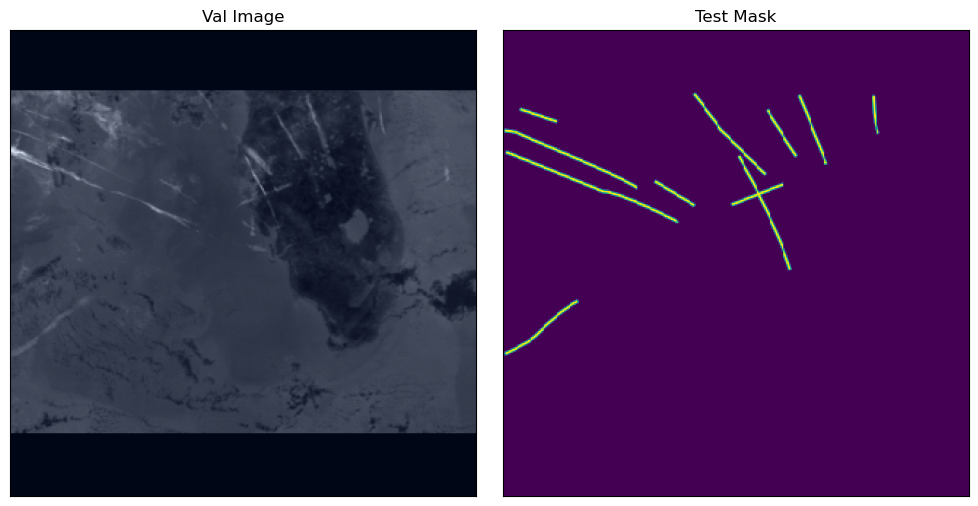

In [4]:
# test_image_paths = sorted(glob.glob("data/landsat/*_B3.TIF"))
test_image_paths = sorted(glob.glob("data/test*/image/*.png"))
test_mask_paths = sorted(glob.glob("data/test*/mask/*.png"))


test_dataset = contrail.Dataset(
    test_image_paths,
    test_mask_paths,
    augmentation=contrail.get_test_augmentation(),
    preprocessing=contrail.get_preprocessing(),
)

image, mask = test_dataset[0]
contrail.visualize(val_image=image, test_mask=mask)


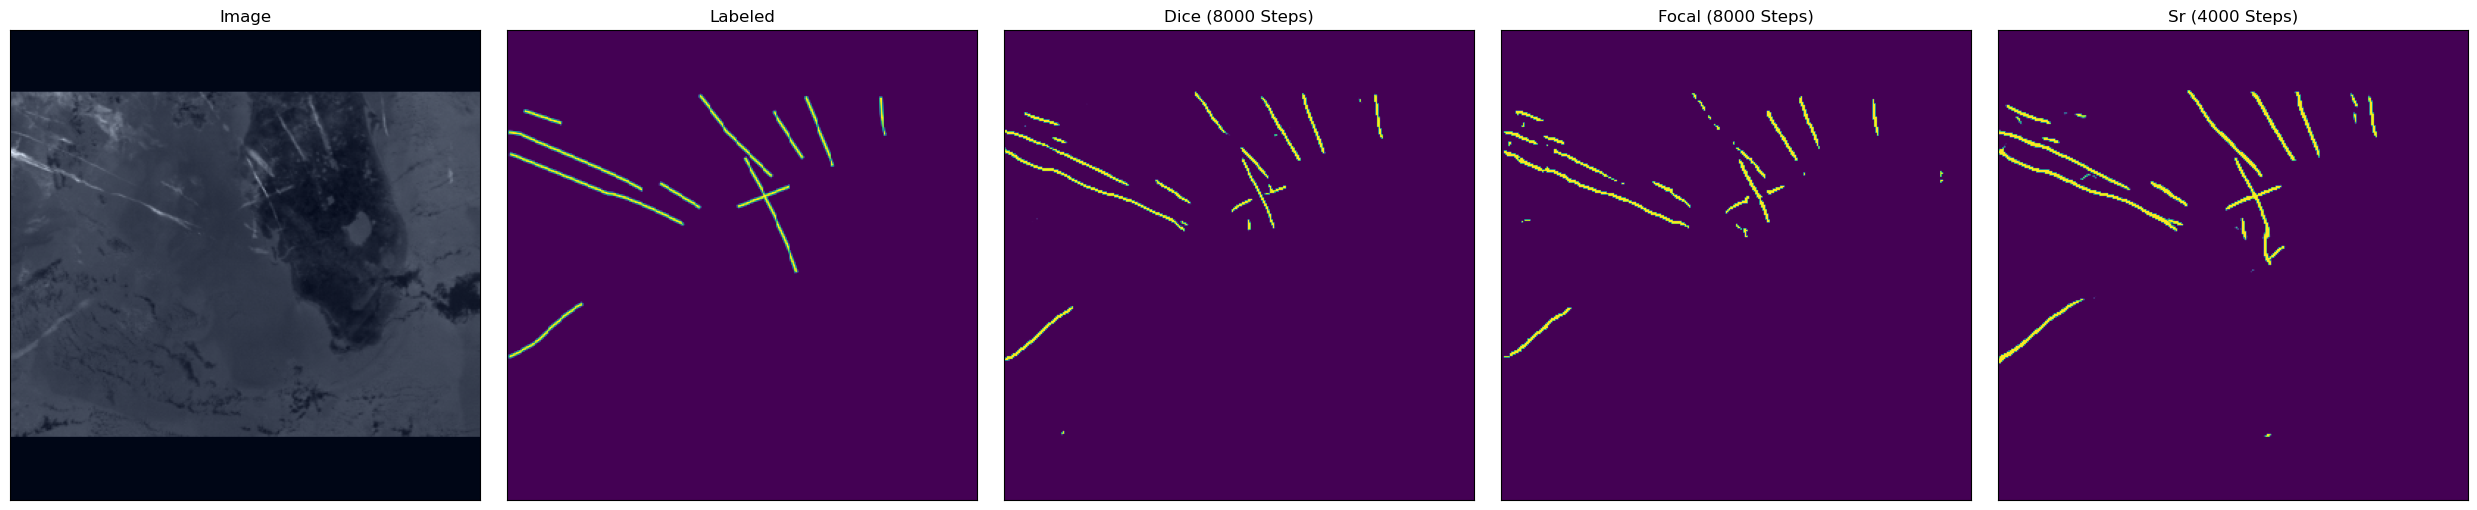

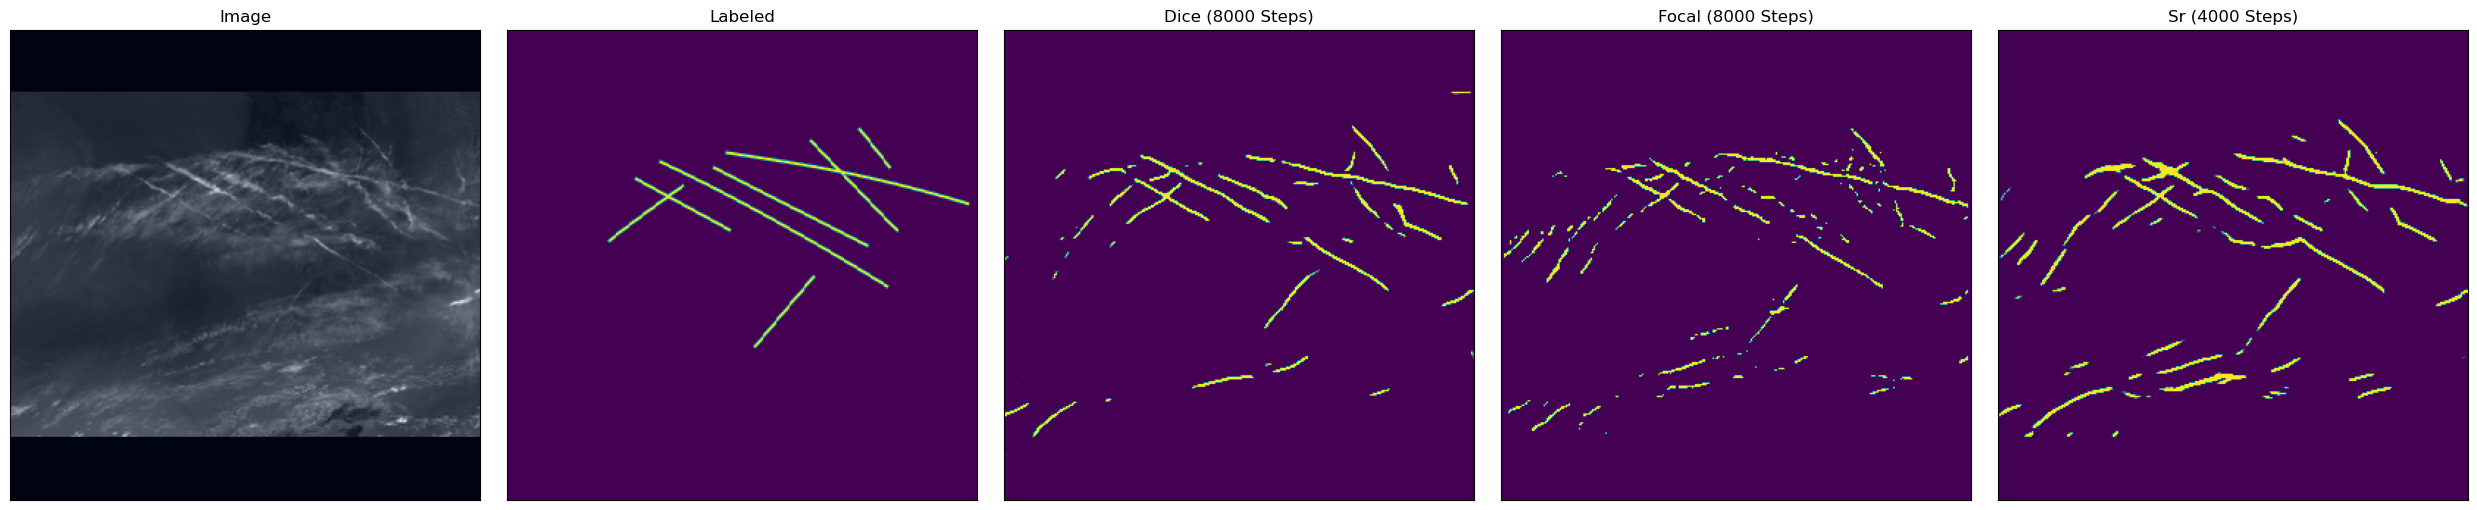

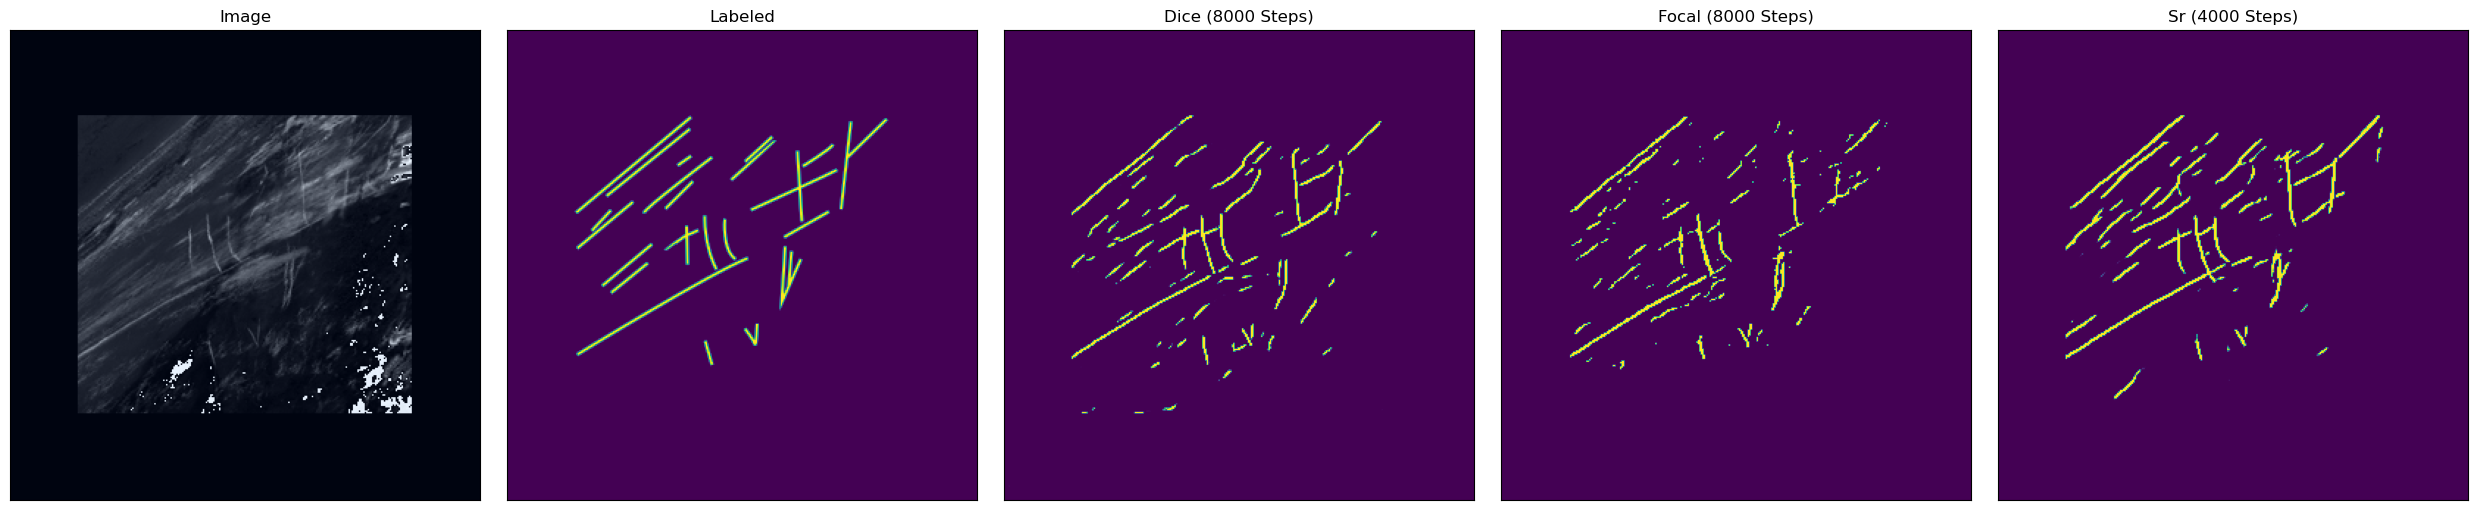

In [5]:
test_dataset = contrail.Dataset(
    test_image_paths,
    test_mask_paths,
    augmentation=contrail.get_test_augmentation(),
    preprocessing=contrail.get_preprocessing(),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=10,
    shuffle=False,
)

batch = next(iter(test_dataloader))

with torch.no_grad():
    model.eval()
    logits = model(batch[0])
    pred_masks_1 = logits.sigmoid()


with torch.no_grad():
    model2.eval()
    logits = model2(batch[0])
    pred_masks_2 = logits.sigmoid()
    pred_masks_2 = np.where(pred_masks_2 > 0.5, 1, 0)

with torch.no_grad():
    model3.eval()
    logits = model3(batch[0])
    pred_masks_3 = logits.sigmoid()


results = []

for i in [0, 5, 9]:
    image = batch[0][i]
    labeled = batch[1][i]
    pred1 = pred_masks_1[i]
    pred2 = pred_masks_2[i]
    pred3 = pred_masks_3[i]

    d = {
        "Image": np.array(image),
        "Labeled": np.array(labeled),
        "Dice (8000 steps)": np.array(pred1),
        "Focal (8000 steps)": np.array(pred2),
        "SR (4000 steps)": np.array(pred3),
    }

    contrail.visualize(**d)
    results.append(d)


pickle.dump(
    results,
    open(f"{outpath}/dice_vs_focal_vs_sr.pkl", "wb"),
)


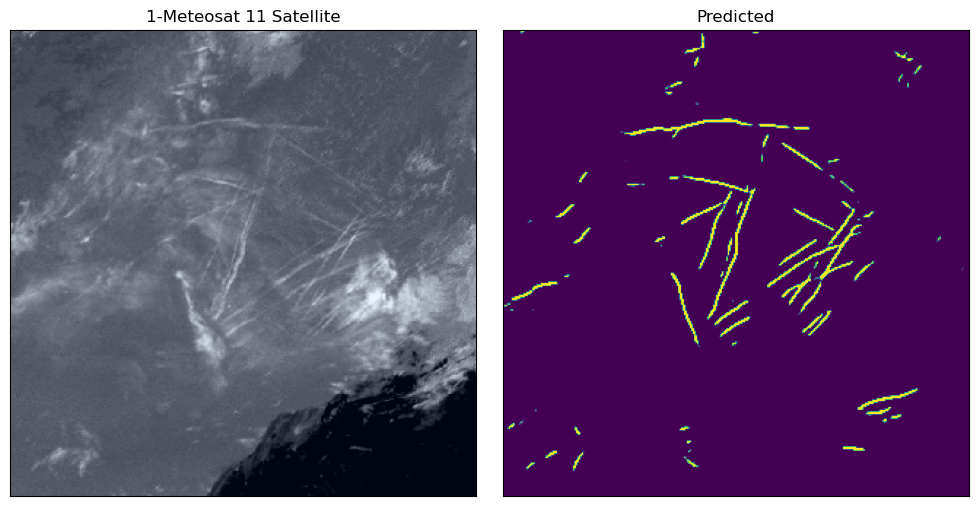

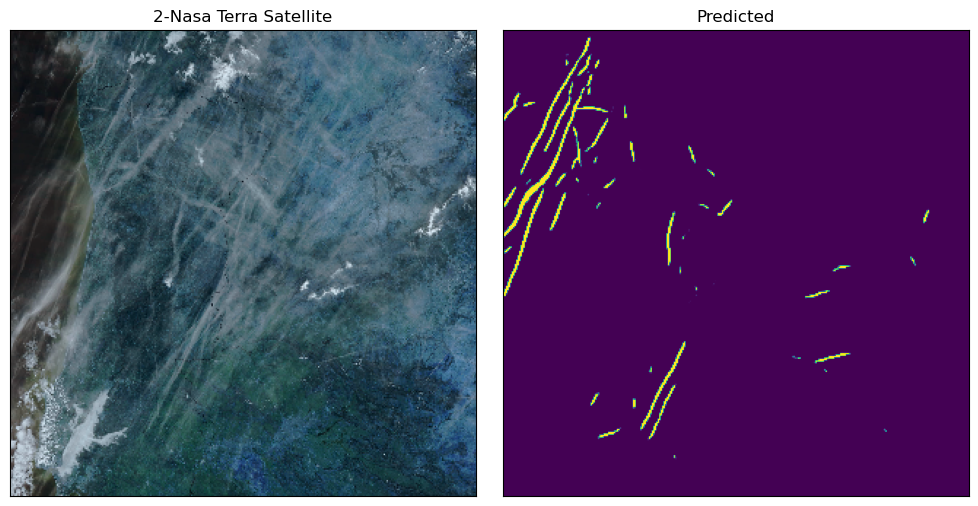

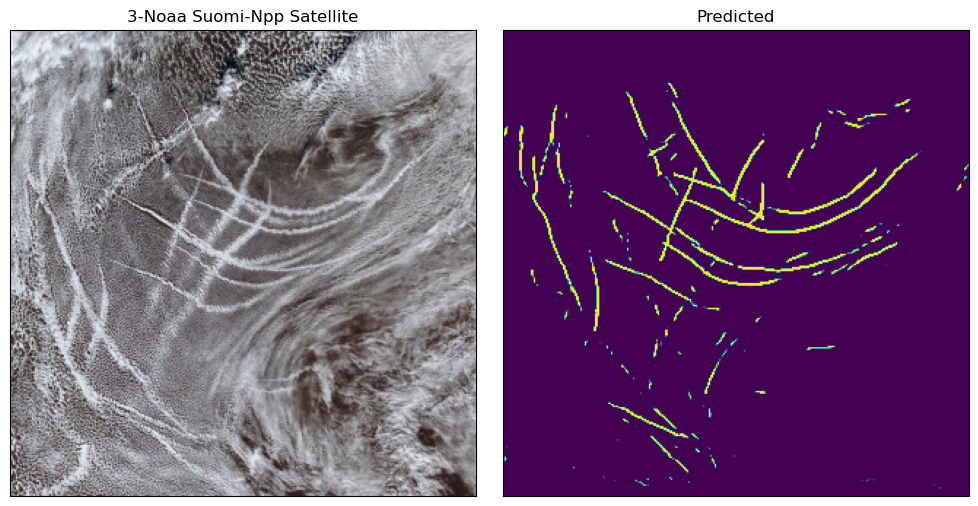

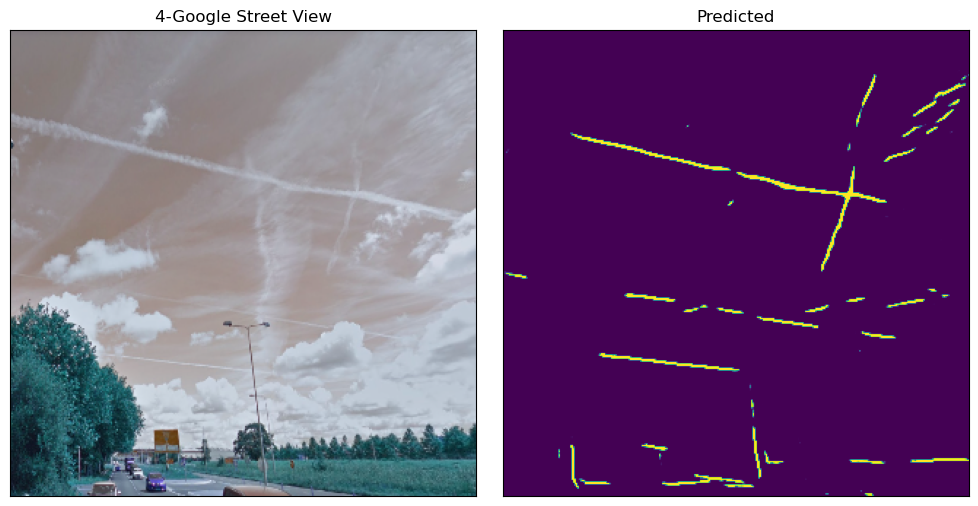

In [19]:
other_image_paths = sorted(glob.glob("data/internet_img/*.[jp][pn]g"))

# other_image_paths = sorted(glob.glob("data/landsat/*B10.TIF"))

other_dataset = contrail.Dataset(
    other_image_paths,
    augmentation=contrail.get_test_augmentation(),
    preprocessing=contrail.get_preprocessing(),
)

other_dataloader = DataLoader(
    other_dataset,
    batch_size=10,
    shuffle=False,
)

batch = next(iter(other_dataloader))

with torch.no_grad():
    model3.eval()
    logits = model3(batch)

pred_masks = logits.sigmoid()

results = []

for i, (image, pred) in enumerate(zip(batch, pred_masks)):
    d = {
        Path(other_image_paths[i]).stem: image.numpy(),
        "Predicted": pred.numpy(),
    }

    contrail.visualize(**d)
    results.append(d)


# pickle.dump(results, open(f"{outpath}/different_image_sources.pkl", "wb"))
